In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

In [2]:
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def make_table():
    real_path = 'warehouse_real_fixed_stores'
    # real_path = 'warehouse_real'

    just_in_time_paths = {
        16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/just_in_time',
    }
    # transformed_nv_paths = {
    #     16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/transformed_nv',
    # }

    # Add normalized paths
    symmetry_aware_normalized_paths = {
        16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware_normalized',
    }
    vanilla_normalized_paths = {
        16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/vanilla_normalized',
    }
    gnn_normalized_paths = {
        16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/GNN_normalized',
    }
    symmetry_aware_decentralized_normalized_paths = {
        16: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware_decentralized_normalized',
    }

    sort_by = 'dev_loss'
    pick_row_from_run_by = 'dev_loss'
    results_interpretor = rri.RayResultsinterpreter()
    df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': [2, 4, 7]}, custom_data_filler)
    df_vanilla_normalized = results_interpretor.make_table(vanilla_normalized_paths, {'store_underage_cost': [2, 4, 7]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    df_symmetry_aware_normalized = results_interpretor.make_table(symmetry_aware_normalized_paths, {'store_underage_cost': [2, 4, 7]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    df_gnn_normalized = results_interpretor.make_table(gnn_normalized_paths, {'store_underage_cost': [2, 4, 7]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    df_symmetry_aware_decentralized_normalized = results_interpretor.make_table(symmetry_aware_decentralized_normalized_paths, {'store_underage_cost': [2, 4, 7]}, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    
    df_just_in_time.insert(1, 'Architecture Class', "Oracle")
    df_vanilla_normalized.insert(1, 'Architecture Class', "Vanilla Normalized")
    df_symmetry_aware_normalized.insert(1, 'Architecture Class', "Symmetry Aware Normalized")
    df_gnn_normalized.insert(1, 'Architecture Class', "GNN Normalized")
    df_symmetry_aware_decentralized_normalized.insert(1, 'Architecture Class', "Symmetry Aware Decentralized Normalized")

    df_just_in_time.insert(1, 'hyperparam_name', "just_in_time_real_fixed_stores")  
    df_vanilla_normalized.insert(1, 'hyperparam_name', "data_driven_net_real_fixed_stores_normalized")
    df_symmetry_aware_normalized.insert(1, 'hyperparam_name', "symmetry_aware_real_fixed_stores_normalized")
    df_gnn_normalized.insert(1, 'hyperparam_name', "symmetry_GNN_real_fixed_stores_normalized")
    df_symmetry_aware_decentralized_normalized.insert(1, 'hyperparam_name', "symmetry_aware_decentralized_real_fixed_stores_normalized")
    
    df_just_in_time.insert(1, 'NN_name', "just_in_time")
    df_vanilla_normalized.insert(1, 'NN_name', "data_driven")
    df_symmetry_aware_normalized.insert(1, 'NN_name', "symmetry_aware_real_data")
    df_gnn_normalized.insert(1, 'NN_name', "symmetry_GNN_real_data")
    df_symmetry_aware_decentralized_normalized.insert(1, 'NN_name', "symmetry_aware_real_data")
    
    df = pd.concat([df_just_in_time,
                    df_vanilla_normalized, df_symmetry_aware_normalized, df_gnn_normalized, df_symmetry_aware_decentralized_normalized])
    
    min_dev_loss = df.groupby(['store_underage_cost'])['Dev Loss'].transform('min')
    df['Dev Gap %'] = -((df['Dev Loss'] - min_dev_loss) / min_dev_loss) * 100
    df.insert(df.columns.get_loc(df.columns[-2]), 'Dev Gap %', df.pop('Dev Gap %'))
    df.drop(columns=['# of stores', '# of runs'], inplace=True)
    df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
    cols = df.columns.tolist()
    cols.remove('store_underage_cost')
    cols = ['store_underage_cost'] + cols
    df = df[cols]
    return df

In [3]:
def collect_data_and_plot(df, test_mode, setting_name, x_axis_value):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        normalized = 'Normalized' in row['Architecture Class']
        decentralized = 'Decentralized' in row['Architecture Class']
        return f"results/one_warehouse_real/{row['NN_name']}_{normalized}_{decentralized}/{row['store_underage_cost']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_profit = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 416
        batch_size = 416
        num_batches = n_samples // batch_size
        num_steps = 50
        start_step = 16
        n_stores = 16
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        
        relevant_data = data.iloc[relevant_indices]
        
        avg_s_underage.append(-relevant_data['s_underage_costs'].mean() / row['store_underage_cost'])
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / row['store_underage_cost'])
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / row['store_underage_cost'])
        avg_profit.append(-relevant_data['s_underage_costs'].sum() * n_stores - relevant_data['s_holding_costs'].sum() * n_stores - relevant_data['w_holding_costs'].sum())

    df['avg_s_underage'] = avg_s_underage
    df['avg_s_holding'] = avg_s_holding
    df['avg_w_holding'] = avg_w_holding
    df['avg_profit'] = avg_profit

    # Calculate relative profit
    oracle_profits = df[df['Architecture Class'] == 'Oracle'].set_index('store_underage_cost')['avg_profit']
    df['relative_profit'] = df.apply(lambda row: (row['avg_profit'] / oracle_profits[row['store_underage_cost']]) * 100, axis=1)

    plot_data = df.pivot(index=x_axis_value, columns='Architecture Class', 
                         values=['relative_profit', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Profit % relative to Oracle', 'Store Revenue / (average unit underage cost)', 'Store Holding Cost / (average unit underage cost)', 'Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['relative_profit', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    if x_axis_value == 'store_underage_cost':
        x_values = [2, 4, 7]
    color_map = {
        "Vanilla": "#ff7f0e",  # Orange
        "Symmetry Aware": "#1f77b4",  # Blue
        "GNN": "#2ca02c",  # Green
        "Oracle": "#9467bd",  # Purple
        "Symmetry Aware Decentralized": "#d62728",  # Red
        "Vanilla Normalized": "#ff7f0e",  # Orange (same as non-normalized)
        "Symmetry Aware Normalized": "#1f77b4",  # Blue (same as non-normalized)
        "GNN Normalized": "#2ca02c",  # Green (same as non-normalized)
        "Symmetry Aware Decentralized Normalized": "#d62728",  # Red (same as non-normalized)
    }

    linestyle_map = {
        'Vanilla': '-',
        'Symmetry Aware': '-',
        'GNN': '-',
        'Oracle': '-',
        'Symmetry Aware Decentralized': '-',
        'Vanilla Normalized': '--',
        'Symmetry Aware Normalized': '--',
        'GNN Normalized': '--',
        'Symmetry Aware Decentralized Normalized': '--',
    }

    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Oracle':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_map[arch], linestyle=linestyle_map[arch])
        
        ax.set_xlabel('Average unit underage cost')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


In [4]:
df = make_table()

In [5]:
# Print the 'path' column, showing only the last part of the path
for path in df['path']:
    print(path)

/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/GNN_normalized/run_2024-10-01_20-58-33/run_72c1e_00009_9_context=256,learning_rate=0.0100,samples=4,store_underage_cost=2,training_n_samples=416,warehouse_holding_cost=1_2024-10-01_20-58-34
/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/just_in_time/run_2024-10-01_21-00-47/run_c2a51_00000_0_samples=1,store_underage_cost=2,training_n_samples=416,warehouse_holding_cost=1.5000,warehouse_lead_time=6_2024-10-01_21-00-47
/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/symmetry_aware_decentralized_normalized/run_2024-10-01_20-59-20/run_8e5c7_00024_24_context=0,learning_rate=0.0100,samples=9,store_underage_cost=2,training_n_samples=416,warehouse_holding_cost=1._2024-10-01_20-59-20
/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/symmetry_aware_normalized/run_2024-10-01_20-58-13/run_668ee_00024_24_context=256,learning_rate=0.0100,samples=9,store_underage_cost=2,training_n_samples=416,warehouse_ho

In [6]:
df

,store_underage_cost,NN_name,hyperparam_name,Architecture Class,Train Loss,Dev Loss,path,Dev Gap %,Learning Rate
0,2,symmetry_GNN_real_data,symmetry_GNN_real_fixed_stores_normalized,GNN Normalized,-73.647557,-69.061700,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,31.722371,0.010
0,2,just_in_time,just_in_time_real_fixed_stores,Oracle,-109.959408,-101.148358,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,0.000000,NaN
0,2,symmetry_aware_real_data,symmetry_aware_decentralized_real_fixed_stores...,Symmetry Aware Decentralized Normalized,-72.706062,-68.138592,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,32.634999,0.010
0,2,symmetry_aware_real_data,symmetry_aware_real_fixed_stores_normalized,Symmetry Aware Normalized,-76.073870,-67.469050,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,33.296939,0.010
0,2,data_driven,data_driven_net_real_fixed_stores_normalized,Vanilla Normalized,-74.042525,-65.274949,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,35.466131,0.001
1,4,symmetry_GNN_real_data,symmetry_GNN_real_fixed_stores_normalized,GNN Normalized,-166.746667,-152.289062,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,24.723755,0.010
1,4,just_in_time,just_in_time_real_fixed_stores,Oracle,-219.923500,-202.306932,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,0.000000,NaN
1,4,symmetry_aware_real_data,symmetry_aware_decentralized_real_fixed_stores...,Symmetry Aware Decentralized Normalized,-163.569793,-150.051948,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,25.829557,0.001
1,4,symmetry_aware_real_data,symmetry_aware_real_fixed_stores_normalized,Symmetry Aware Normalized,-170.752841,-149.924597,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,25.892506,0.010
1,4,data_driven,data_driven_net_real_fixed_stores_normalized,Vanilla Normalized,-164.185615,-147.625133,/user/ml4723/Prj/NIC/ray_results/warehouse_rea...,27.029128,0.001


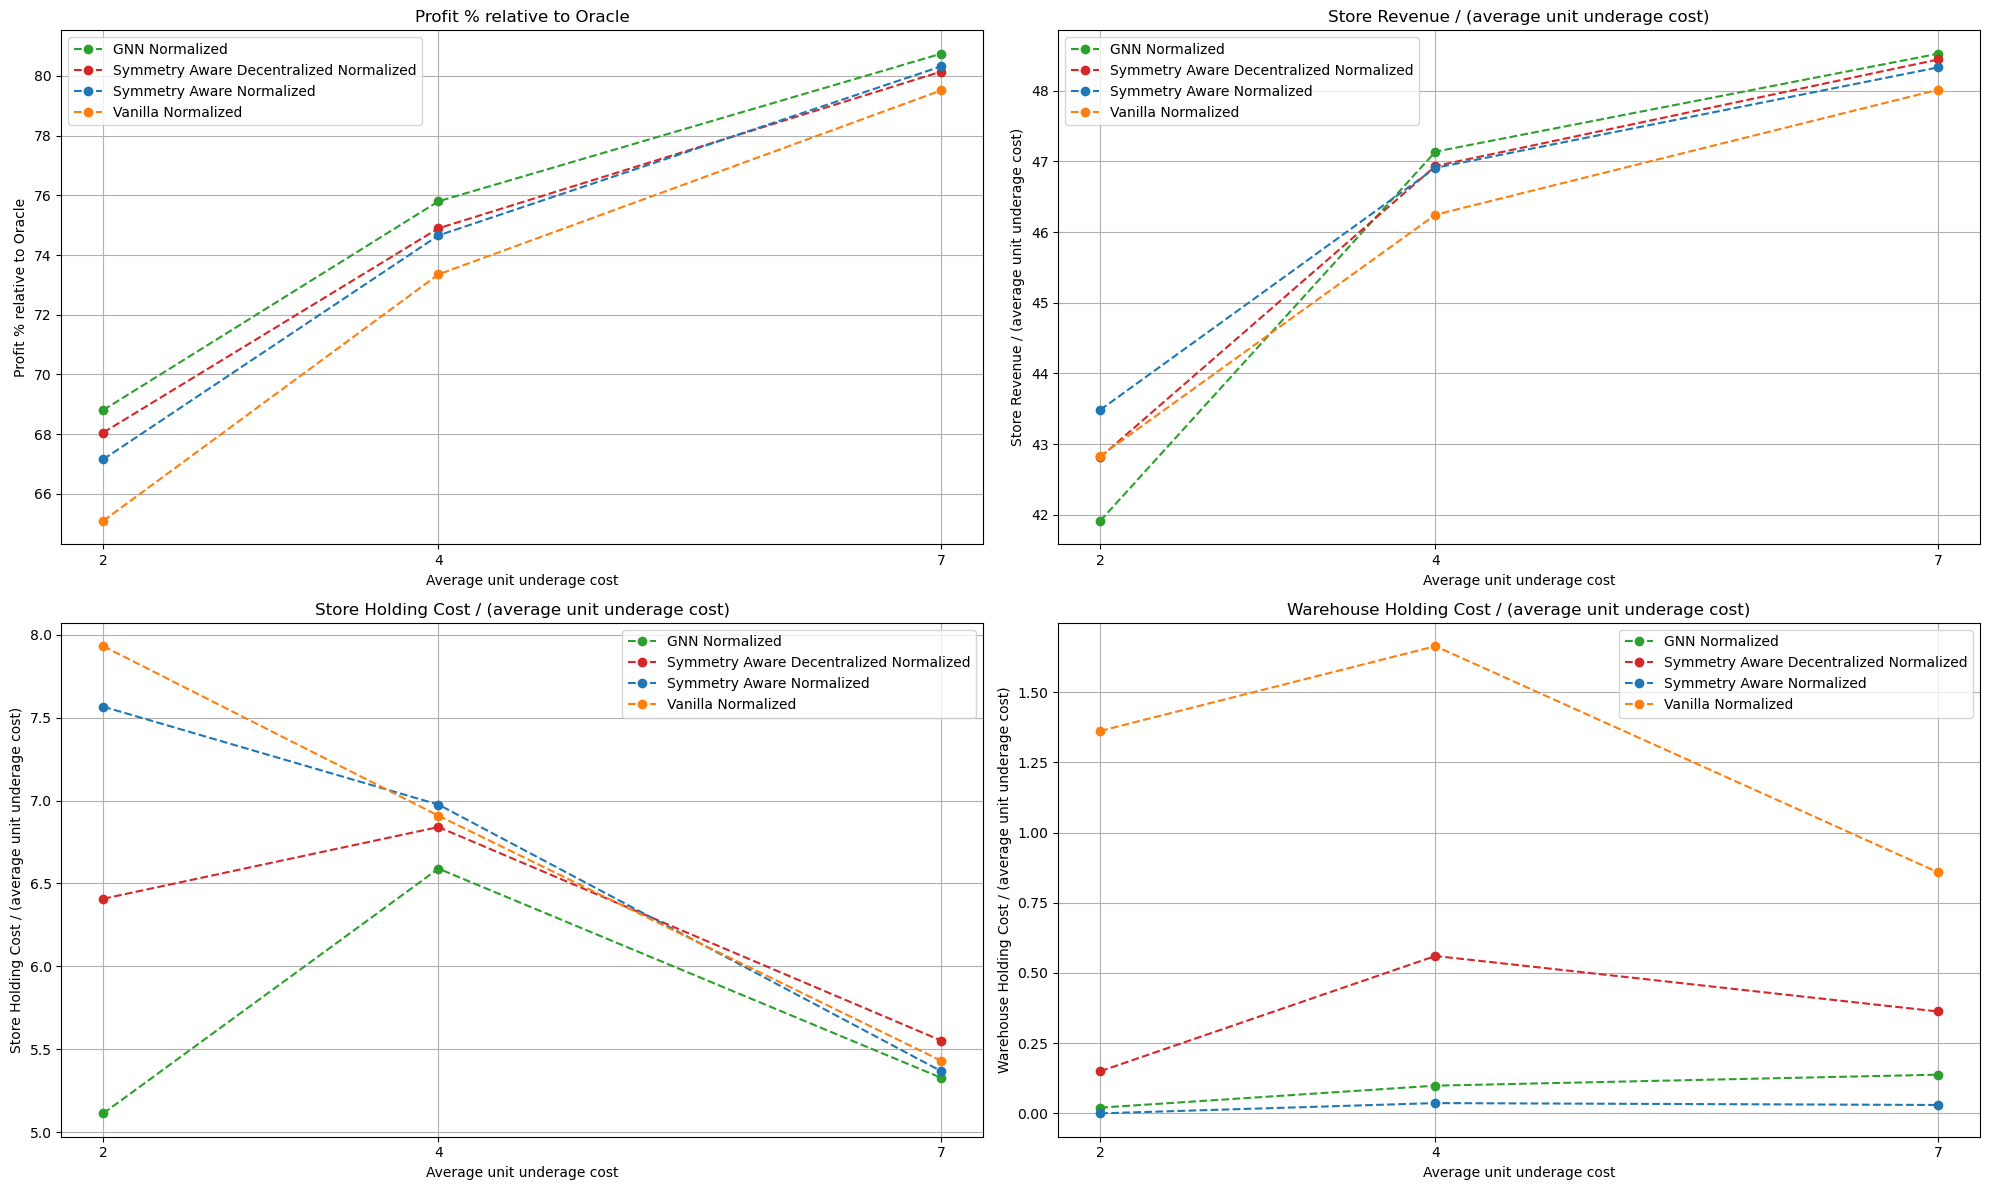

In [7]:
df_t = collect_data_and_plot(df, "test_on_dev", "one_warehouse_real_lost_demand_fixed_stores", "store_underage_cost")

In [ ]:
Symmetry Aware Decentralized Normalized 
symmetry_aware_decentralized_real_fixed_stores_normalized
/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/symmetry_aware_decentralized_normalized/run_2024-09-29_22-23-37/run_ffbd1_00018_18_context=0,learning_rate=0.0100,samples=7,store_underage_cost=4,training_n_samples=416_2024-09-29_22-23-37

Symmetry Aware Normalize
symmetry_aware_real_fixed_stores_normalized
/user/ml4723/Prj/NIC/ray_results/warehouse_real_fixed_stores/symmetry_aware_normalized/run_2024-09-29_22-23-08/run_eeaa5_00000_0_context=256,learning_rate=0.0100,samples=1,store_underage_cost=4,training_n_samples=416_2024-09-29_22-23-08

In [32]:
df_t.drop(columns=['path', 'NN_name', 'hyperparam_name', 'Learning Rate'], inplace=True)

In [33]:
print(df_t.to_string())

   store_underage_cost                       Architecture Class  Train Loss    Dev Loss  Dev Gap %  avg_s_underage  avg_s_holding  avg_w_holding    avg_profit  relative_profit
0                    4                           GNN Normalized -178.865371 -163.831201  23.422011       47.663004       4.512440   5.562586e+00  1.025626e+07        76.568739
0                    4                                   Oracle -233.280130 -213.940328   0.000000       55.901950       0.000673   2.200787e-08  1.339484e+07       100.000000
0                    4  Symmetry Aware Decentralized Normalized -178.278600 -162.992594  23.813993       48.417457       5.229909   9.937769e+00  1.019960e+07        76.145733
0                    4                Symmetry Aware Normalized -179.395815 -162.114660  24.224357       48.345911       5.214215   7.953963e+00  1.021593e+07        76.267621
0                    4                       Vanilla Normalized -176.551054 -159.409785  25.488669       46.706514      

In [77]:
df

,store_underage_cost,Architecture Class,Train Loss,Dev Loss,Test Loss,Test Gap %,avg_s_underage,avg_s_holding,avg_w_holding,avg_profit
0,4,GNN,-171.822484,-156.620643,-115.101613,43.233663,46.245418,16.458415,16.185861,13.601141
0,4,Oracle,-233.280130,-223.605101,-202.763856,0.000000,50.692152,0.001188,0.000000,50.690963
0,4,Symmetry Aware,-181.235345,-168.182141,-133.438994,34.189950,47.558171,10.182733,64.251020,-26.875582
0,4,Symmetry Aware Decentralized,-171.246490,-156.713191,-94.519122,53.384630,44.570780,5.055220,254.172480,-214.656920
0,4,Vanilla,-179.211457,-169.137754,-155.213492,23.451105,46.970803,7.380502,12.590838,26.999462
1,6,GNN,-277.388412,-260.604801,-174.366720,42.670469,48.738347,18.172674,24.072499,6.493175
1,6,Oracle,-349.923022,-335.408988,-304.148170,0.000000,50.692151,0.000792,0.000000,50.691359
1,6,Symmetry Aware,-285.239210,-266.339810,-196.543336,35.379083,48.874827,9.342029,108.409208,-68.876410
1,6,Symmetry Aware Decentralized,-246.721755,-176.357055,-165.656200,45.534376,29.633230,0.753779,20.321354,8.558096
1,6,Vanilla,-281.532561,-266.810781,-246.348374,19.003828,47.719887,5.987918,10.782479,30.949489
